#1.Utilizes the wget command to download several Python files from the PyTorch vision library

In [1]:
#prepare the utils from torchvision framework
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py

--2024-04-20 05:47:05--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23628 (23K) [text/plain]
Saving to: ‘transforms.py’

transforms.py       100%[===================>]  23.07K  --.-KB/s    in 0.007s  

2024-04-20 05:47:05 (3.09 MB/s) - ‘transforms.py’ saved [23628/23628]

--2024-04-20 05:47:05--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K)

#2.Downloading and preparing the Penn Fudan Pedestrian dataset

In [2]:
# prepare the datasets
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip -d PennFudanPed

--2024-04-20 05:47:10--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  13.2MB/s    in 4.8s    

2024-04-20 05:47:15 (10.7 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/PennFudanPed/
  inflating: PennFudanPed/PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/PennFudanPed/Annotation/
  inflating: PennFudanPed/PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/PennFudanPed/Annotation/FudanPed00004.txt  


#2B.Custom dataset class that can be used to load and process the dataset

In [3]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
DATA_PATH = 'PennFudanPed/PennFudanPed/'
os.listdir(DATA_PATH)

['Annotation', 'readme.txt', 'PedMasks', 'added-object-list.txt', 'PNGImages']

In [5]:
# code is from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [6]:
# code is from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [7]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 67.0MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

#3.Training Model

In [8]:
# code is from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
from engine import train_one_epoch, evaluate
import utils

# use our dataset and defined transformations
dataset = PennFudanDataset(DATA_PATH, get_transform(train=True))
dataset_test = PennFudanDataset(DATA_PATH, get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 100 epochs
num_epochs = 100

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("Training Done, Dhik!")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [0]  [ 0/60]  eta: 0:04:12  lr: 0.000090  loss: 7.2266 (7.2266)  loss_classifier: 0.9193 (0.9193)  loss_box_reg: 0.3550 (0.3550)  loss_mask: 5.9039 (5.9039)  loss_objectness: 0.0314 (0.0314)  loss_rpn_box_reg: 0.0170 (0.0170)  time: 4.2078  data: 0.3232  max mem: 2496
Epoch: [0]  [10/60]  eta: 0:00:45  lr: 0.000936  loss: 2.9895 (4.5633)  loss_classifier: 0.5588 (0.5455)  loss_box_reg: 0.3016 (0.2972)  loss_mask: 2.0123 (3.6886)  loss_objectness: 0.0264 (0.0252)  loss_rpn_box_reg: 0.0052 (0.0069)  time: 0.9011  data: 0.0408  max mem: 2769
Epoch: [0]  [20/60]  eta: 0:00:28  lr: 0.001783  loss: 0.8601 (2.7167)  loss_classifier: 0.1518 (0.3402)  loss_box_reg: 0.1897 (0.2363)  loss_mask: 0.5230 (2.1126)  loss_objectness: 0.0143 (0.0201)  loss_rpn_box_reg: 0.0052 (0.0075)  time: 0.5469  data: 0.0115  max mem: 2769
Epoch: [0]  [30/60]  eta: 0:00:19  lr: 0.002629  loss: 0.6739 (2.0438)  loss_classifier: 0.1252 (0.2667)  loss_box_reg: 0.1878 (0.2215)  loss_mask: 0.3075 (1.5305)  loss_ob

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [0]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.4773 (1.3132)  loss_classifier: 0.0521 (0.1735)  loss_box_reg: 0.1864 (0.2177)  loss_mask: 0.2101 (0.9017)  loss_objectness: 0.0045 (0.0125)  loss_rpn_box_reg: 0.0048 (0.0079)  time: 0.5402  data: 0.0088  max mem: 3499
Epoch: [0] Total time: 0:00:36 (0.6112 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:23  model_time: 0.2865 (0.2865)  evaluator_time: 0.0224 (0.0224)  time: 0.4697  data: 0.1593  max mem: 3499
Test:  [49/50]  eta: 0:00:00  model_time: 0.1126 (0.1342)  evaluator_time: 0.0096 (0.0163)  time: 0.1446  data: 0.0042  max mem: 3499
Test: Total time: 0:00:08 (0.1628 s / it)
Averaged stats: model_time: 0.1126 (0.1342)  evaluator_time: 0.0096 (0.0163)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

#4.Testing the model

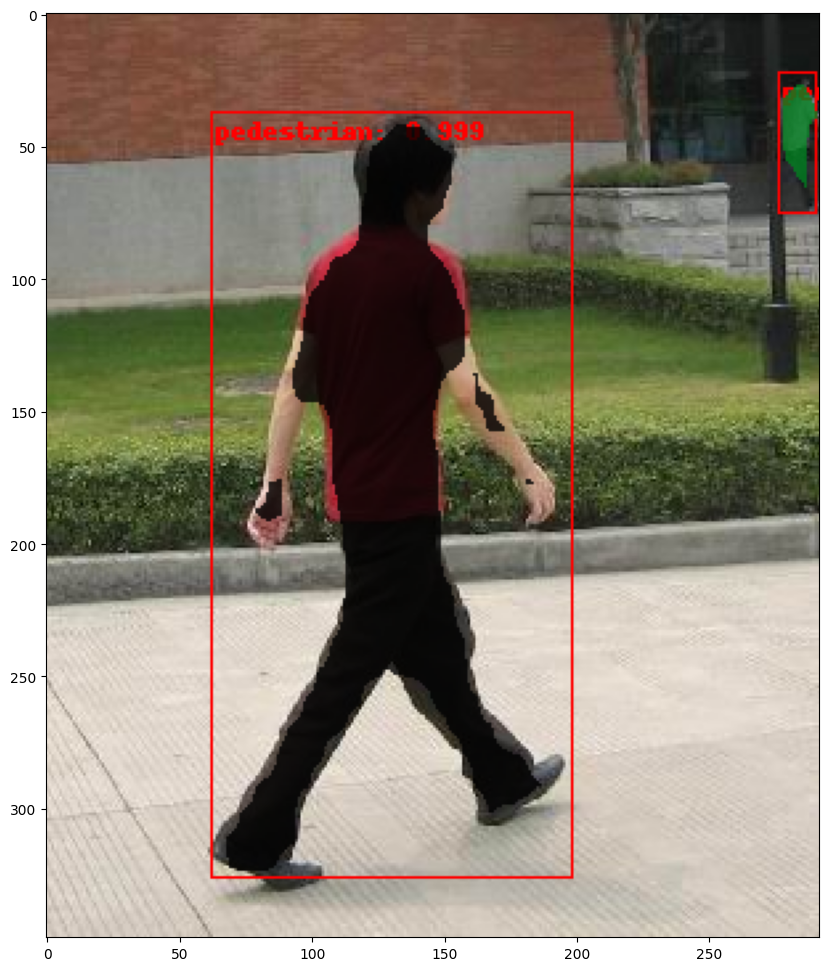

In [12]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(DATA_PATH + "PNGImages/FudanPed00035.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.8).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.8)


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [14]:
torch.save(model.state_dict(), "model.pth")

print("Model saved successfully!")

Model saved successfully!


#5.Testing from Random Picture

In [20]:
from google.colab import drive

# Mount your Google Drive (authentication required)
drive.mount('/content/gdrive')

Mounted at /content/gdrive


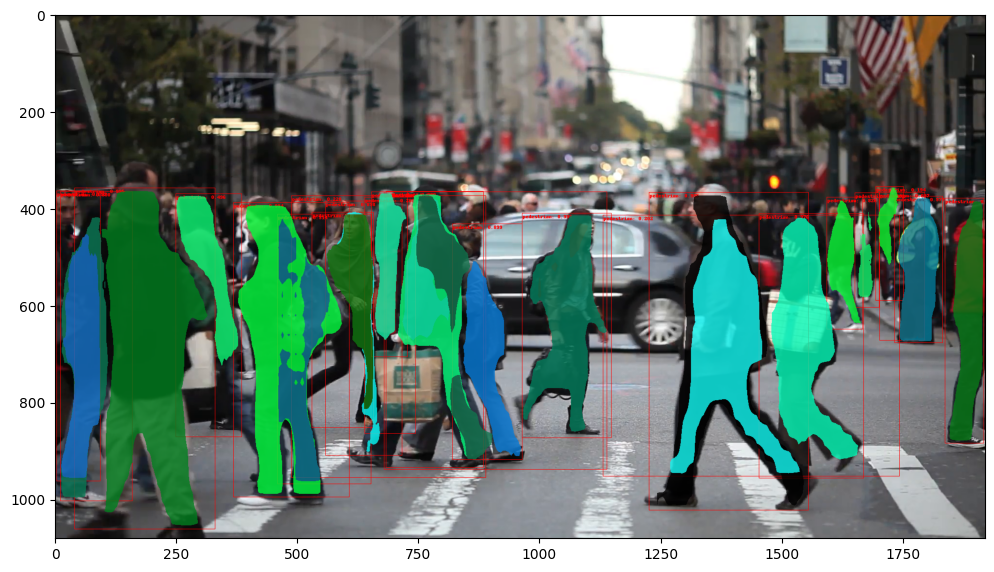

In [23]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("/content/gdrive/MyDrive/Sample_Random_Data_Pedestrian/pedestrian_1.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.8).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.8)


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

Total Pedestrian Detected: 24


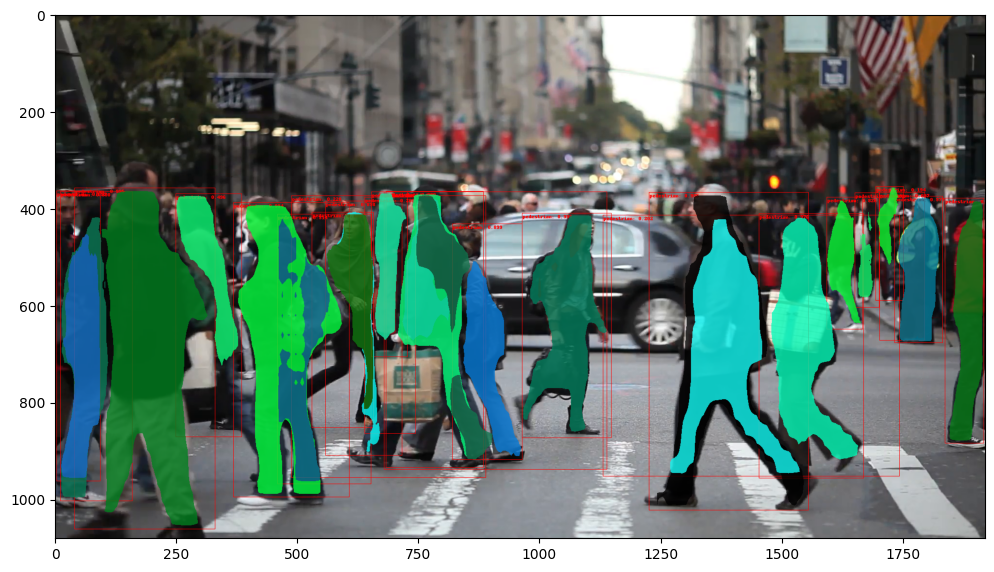

In [26]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("/content/gdrive/MyDrive/Sample_Random_Data_Pedestrian/pedestrian_1.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
  x = eval_transform(image)
  # convert RGBA -> RGB and move to device
  x = x[:3, ...].to(device)
  predictions = model([x, ])
  pred = predictions[0]

  # Count the total number of bounding boxes
  num_boxes = len(pred["boxes"])

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.8).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.8)

# Print the total number of bounding boxes detected
print(f"Total Pedestrian Detected: {num_boxes}")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()


Total Pedestrian Detected: 61


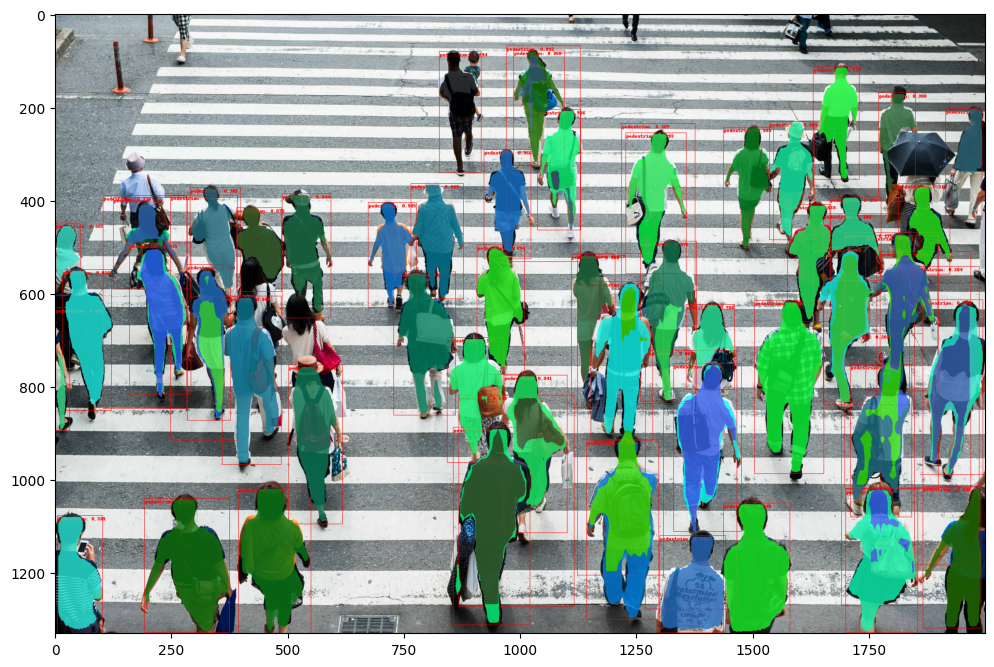

In [28]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("/content/gdrive/MyDrive/Sample_Random_Data_Pedestrian/pedestrian_2.jpg")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
  x = eval_transform(image)
  # convert RGBA -> RGB and move to device
  x = x[:3, ...].to(device)
  predictions = model([x, ])
  pred = predictions[0]

  # Count the total number of bounding boxes
  num_boxes = len(pred["boxes"])

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.8).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.8)

# Print the total number of bounding boxes detected
print(f"Total Pedestrian Detected: {num_boxes}")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()


Total Pedestrian Detected: 6


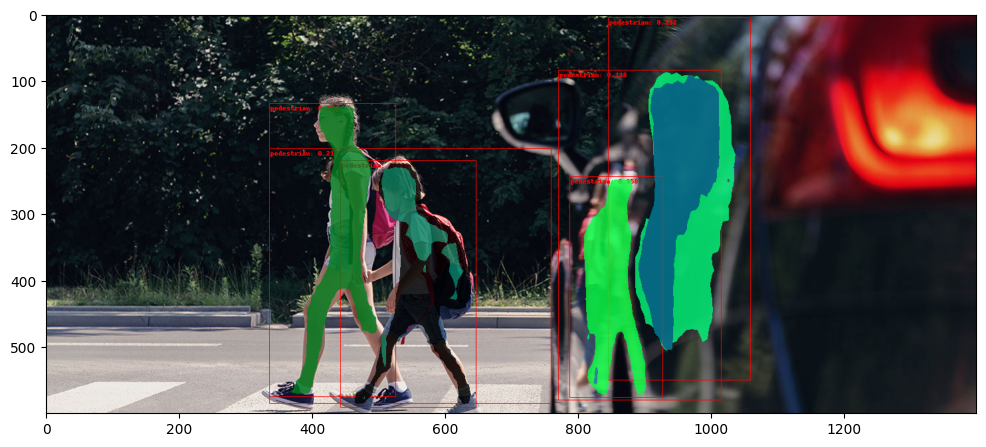

In [29]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("/content/gdrive/MyDrive/Sample_Random_Data_Pedestrian/pedestrian_3.jpg")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
  x = eval_transform(image)
  # convert RGBA -> RGB and move to device
  x = x[:3, ...].to(device)
  predictions = model([x, ])
  pred = predictions[0]

  # Count the total number of bounding boxes
  num_boxes = len(pred["boxes"])

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.8).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.8)

# Print the total number of bounding boxes detected
print(f"Total Pedestrian Detected: {num_boxes}")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()


Total Pedestrian Detected: 20


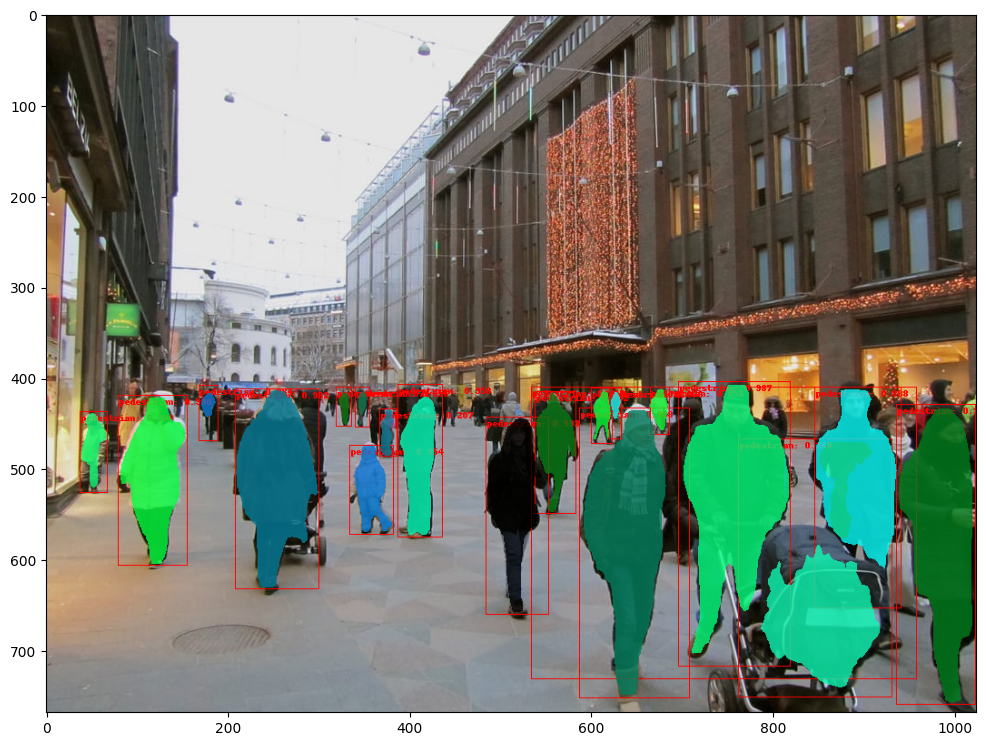

In [40]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("/content/gdrive/MyDrive/Sample_Random_Data_Pedestrian/Pedestrians_4.jpg")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
  x = eval_transform(image)
  # convert RGBA -> RGB and move to device
  x = x[:3, ...].to(device)
  predictions = model([x, ])
  pred = predictions[0]

  # Count the total number of bounding boxes
  num_boxes = len(pred["boxes"])

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.8).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.8)

# Print the total number of bounding boxes detected
print(f"Total Pedestrian Detected: {num_boxes}")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()


Total Pedestrian Detected: 25


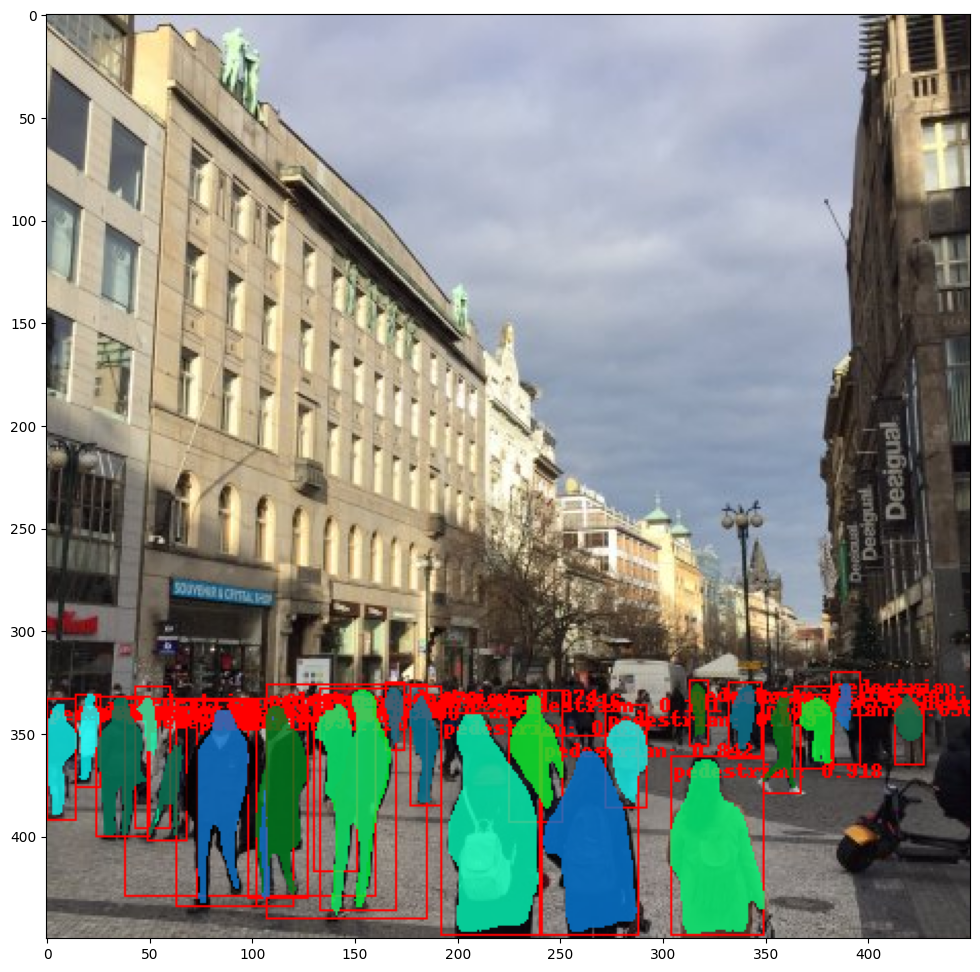

In [41]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("/content/gdrive/MyDrive/Sample_Random_Data_Pedestrian/pedestrian_5.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
  x = eval_transform(image)
  # convert RGBA -> RGB and move to device
  x = x[:3, ...].to(device)
  predictions = model([x, ])
  pred = predictions[0]

  # Count the total number of bounding boxes
  num_boxes = len(pred["boxes"])

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.8).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.8)

# Print the total number of bounding boxes detected
print(f"Total Pedestrian Detected: {num_boxes}")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()
